In [1]:
## Spark session libraries
import findspark
findspark.init()

from pyspark import SparkContext
from pyspark import SQLContext

## Required for parsing the file as csv
import csv
from io import StringIO
from itertools import islice, repeat

## For preprocessing
from re import search, split, sub, compile as comp
import numpy as np

## For Plots
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import cm, colors


import warnings

In [2]:
sc.stop()
sc = SparkContext(appName="SDDM", master='local[*]')
print(sc.pythonVer)
print (sc.master)
sc

3.7
local[*]


<SparkContext master=local[*] appName=SDDM>

In [3]:
def parseCSV(csvRow) :
    data = StringIO(csvRow)
    dataReader = csv.reader(data, lineterminator = '')
    return(next(dataReader))

def readFileAsCSV(session, filepath):
    try:
        data = session.textFile(name = str(filepath))
        data = data.map(parseCSV)
        #data = session.read.format("csv").option("inferSchema", True).option("header", True).load(filepath)
        #print('File read successfully!')
    except:
        print('Failed to read the file!')
        data = []
    return data

def tickTime(x):
    try:
        m = int(x[4][0:2])
        y = int(x[4][6:10])
    except:
        m = 'Issue Month'
        y = 'Issue Year'    
    x.append(str(m))
    x.append(str(y))
    return x

#def lat_long(x):
#    Zip = coords.take(1)[0].index('Zip')
#    Geo = coords.take(1)[0].index('geopoint')
#    
#    Zip = list(map(lambda x: x[Zip], coords.collect()))
#    Geo = list(map(lambda x: x[Geo].split(', '), coords.collect()))
#    coords = [Zip, Geo]

def park_street(x):
    s = x[24]
    s = s.replace('AVENUE','AVE').replace('STREET','ST').replace('BLVD','BL')
    s = s.replace('\sEAST\s',' E ').replace('\sWEST\s',' W ').replace('\sNORTH\s',' N ').replace('\sSOUTH\s',' S ')
    s = s.replace('\sROAD\s',' RD ').replace('\sEXPY\s','EXWY').replace('\sPARKWY\s','PKWY').replace('\sISLAND\s','ISL')
    s = s.replace('\sFIRST\s','1').replace('\sSECOND\s','2').replace('\sTHRID\s','3')
    s = s.replace('\sFOURTH\s','4').replace('\sFIVETH\s','5').replace('\sSIXTH\s','6')
    s = s.replace('\sSEVENTH\s','7').replace('\sEIGHTH\s','8').replace('\sNINETH\s','9').replace('\sTENTH\s','10')
    s = s.split()
    result = [x if not search(r'\d', x) else sub('[^0-9]','', x) for x in s]
    result = ' '.join(result)
    x[24] = result.lower()
    return x

def preprocessedCSV(session, filepath):
    '''
    Reads the csv files, and then converts Issue date to date and month
    '''
    data = readFileAsCSV(session, filepath)
    data = data.map(tickTime)
    #data = data.map(lat_long(coords))
    header = data.take(1)[0]
    
    ## Removing the header line
    data = data.mapPartitionsWithIndex(lambda idx, it: islice(it, 1, None) if idx == 0 else it)
    data = data.map(park_street)    
    return data, header


In [4]:
def mk_int(s):
    return s if s.strip() else 'NA'

def coord_street(x):
    s = x[28]
    s = s.replace('AVENUE','AVE').replace('STREET','ST').replace('BLVD','BL')
    s = s.replace('\sEAST\s',' E ').replace('\sWEST\s',' W ').replace('\sNORTH\s',' N ').replace('\sSOUTH\s',' S ')
    s = s.replace('\sROAD\s',' RD ').replace('\sEXPY\s','EXWY').replace('\sPARKWY\s','PKWY').replace('\sISLAND\s','ISL')
    s = s.replace('\sFIRST\s','1').replace('\sSECOND\s','2').replace('\sTHRID\s','3')
    s = s.replace('\sFOURTH\s','4').replace('\sFIVETH\s','5').replace('\sSIXTH\s','6')
    s = s.replace('\sSEVENTH\s','7').replace('\sEIGHTH\s','8').replace('\sNINETH\s','9').replace('\sTENTH\s','10')
    s = s.split()
    result = [x if not search(r'\d', x) else sub('[^0-9]','', x) for x in s]
    result = ' '.join(result)
    x[28] = result.lower()
    return x

def createCoordsFiles(session, filepath):
    coords = readFileAsCSV(session, filepath)    
    ## Indexes
    coords_header = coords.take(1)[0]
    street_index = coords_header.index('FULL_STREE')
    geom_index = coords_header.index('the_geom')
    ## Total physical id: 119972; Unique physical ids: 119797
    physicalid_index = coords_header.index('PHYSICALID')
    ## Removing the first line
    coords = coords.mapPartitionsWithIndex(lambda idx, it: islice(it, 1, None) if idx == 0 else it)
    ## Preprocessing
    coords = coords.map(coord_street)
    
    #coords_row_counts = coords.count()
    grouped_coords = coords.map(lambda x: [x[street_index].lower(), [mk_int(x[0]), mk_int(x[1]), 
                                                         mk_int(x[4]), mk_int(x[5]), 
                                                          x[geom_index].replace('MULTILINESTRING ', '').replace('(','').replace(')', '')]] ).groupByKey().mapValues(list)    

    grouped_physicalid_coords = coords.map(lambda x: [x[physicalid_index], x[geom_index].replace('MULTILINESTRING ', '').replace('(','').replace(')', '')]).groupByKey().mapValues(list)
    try:
        grouped_coords.saveAsTextFile('StreetCordinates')
        grouped_physicalid_coords.saveAsTextFile('PhysicalIDCords')
    except:
        print('Couldnt save the coordinate files')
    return coords, coords_header, grouped_coords, grouped_physicalid_coords 


In [5]:
def getData(sc, filepath, filename, coord_filepath, year):
    tickets = []
    createCoordsFiles(sc, coord_filepath)
    for yr in year:
        filelocation = str(filepath)+str(filename)+str(yr)+".csv"
        print(filelocation)
        parking_data, header = preprocessedCSV(sc, filelocation)
        tickets.append(parking_data)
    return tickets, header

In [10]:
def splitString(x):
    return 

def matchstreet(x):
    #SC = sc.textFile('StreetCordinates')  
    street_names = [y[0] for y in sid.collect()]
    try:
        ind = street_names.index(x[24])
        Coords = sid.collect()[ind][1]
        house_num = x[23]
        cond = '-' in house_num
        if cond:
            h1, h2 = house_num.split('-')
        else:
            h1 = int(house_num)
        for y in Coords:
            if y[0] != 'NA' and y[1] != 'NA' and y[2] != 'NA' and y[3] != 'NA':
                if cond and (('-' in y[0] and '-' in y[1]) or ('-' in y[2] and '-' in y[3])):
                    r1, rh1 = y[0].split('-')
                    r2, rh2 = y[1].split('-')
                    r3, rh3 = y[2].split('-')
                    r4, rh4 = y[3].split('-')
                    r1, r2, r3, r4 = int(r1), int(r2), int(r3), int(r4)
                    if (int(h1) >= r1 and int(h1)<=r2) or (int(h1) >= r3 and int(h1)<=r4):
                        x.append(y[4])
                        break
                else:
                    if not cond and not (('-' in y[0] and '-' in y[1]) or ('-' in y[2] and '-' in y[3])):
                        r1, r2 = int(y[0]), int(y[1])
                        r3, r4 = int(y[2]), int(y[3])
                        if (int(h1) >= r1 and int(h1)<=r2) or (int(h1) >= r3 and int(h1)<=r4):
                            x.append(y[4])
                            break
            else:
                x.append(y[4])
                break
    except:
        x.append('')
    return x

In [7]:
parking_data, header = preprocessedCSV(sc, 'SDDM Data/Parking_Violations_Issued_-_Fiscal_Year_2015.csv')

In [11]:
[matchstreet(x) for x in parking_data.take(10)]

[['7560453867',
  'AN921T',
  'NJ',
  'PAS',
  '02/07/2015',
  '84',
  'DELV',
  'PETER',
  'T',
  '10810',
  '34110',
  '34130',
  '',
  '0010',
  '10',
  '10',
  '356521',
  'T102',
  'A',
  '0847A',
  '',
  'NY',
  'F',
  '158',
  '8 ave',
  '',
  '01/05/0001 12:00:00 PM',
  '408',
  'k7',
  '',
  '',
  '',
  '',
  'WHITE',
  '',
  '0',
  '',
  '0',
  'A 17',
  '84-Platform lifts in low posit',
  '',
  '',
  '',
  '2',
  '2015',
  '-73.82440937731695 40.79194604181897, -73.82386700981641 40.79210322555164'],
 ['8030010837',
  '94866JA',
  'NY',
  'COM',
  '04/29/2015',
  '42',
  'DELV',
  'INTER',
  'T',
  '17570',
  '10410',
  '25390',
  '',
  '0014',
  '14',
  '14',
  '359330',
  'T102',
  'J',
  '0412P',
  '',
  'NY',
  'F',
  '10',
  'e 29 st',
  '',
  '01/05/0001 12:00:00 PM',
  '408',
  'h1',
  '',
  'YYYYY',
  '0800A',
  '0700P',
  'BROWN',
  '',
  '2001',
  '445-6678',
  '0',
  '09 6',
  '42-Exp. Muni-Mtr (Com. Mtr. Z)',
  '',
  '',
  '',
  '4',
  '2015',
  '-73.950257570095

In [13]:
#list(map(matchstreet, parking_data.collect()))

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 44496)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/tushar/anaconda3/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/home/tushar/anaconda3/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/tushar/anaconda3/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/accumulators.py", line 269, in handle
    poll(accum_updates)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/accumu

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/j

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in get_return_value
    format(target_id, ".", name), value)
py

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40511)
Traceback (most recent call last):
  File "/home/tushar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cddd9ae29a73>", line 1, in <module>
    list(map(matchstreet, parking_data.collect()))
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/rdd.py", line 816, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/utils.py", line 63, in deco
    return f(*a, **kw)
  File "/home/tushar/spark-2.4.5-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py", line 328, in g

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
[ [y[0].lower(), y[1][0][1], y[1][0][2]] for y in sid.collect()]

[['28 ave', '215-027', '215-000'],
 ['schermerhorn st', '399', '316'],
 ['arlington ave', '5699', '5602'],
 ['queens bl', '120-011', '0'],
 ['cypress crest ln', 'NA', 'NA'],
 ['walworth st', '131', '72'],
 ['58 st', '799', '700'],
 ['president st', '69', '44'],
 ['driveway', 'NA', 'NA'],
 ['i ave', '699', '600'],
 ['69 ave', '111-099', '110-000'],
 ['tompkins ave', '467', '462'],
 ['105 st', '108-099', '107-000'],
 ['bragg st', '2199', '2100'],
 ['cip sb exit 25 b', 'NA', 'NA'],
 ['alley', 'NA', 'NA'],
 ['n y 9 a', 'NA', 'NA'],
 ['beacon pl', '14-099', '14-024'],
 ['willis ave', '391', '354'],
 ['albright st', '99', '40'],
 ['e 96 st', '85', '2'],
 ['utopia pkwy', '0', '68-000'],
 ['126 st', '6-099', '6-000'],
 ['morris i houses pedestrian path', 'NA', 'NA'],
 ['222 st', '38-099', '38-000'],
 ['mill brook houses pedestrian pth', 'NA', 'NA'],
 ['81 st', '32-099', '32-000'],
 ["hunter's point ave", '31-025', '31-000'],
 ['p ave', '4199', '4100'],
 ['74 st', '56-099', '54-000'],
 ['stone 

In [32]:
parking_data.union(parking_data).count()
#filter(lambda x: x[9]=='13610').collect()

23618466

In [34]:
parking_data.count()

11809233

In [299]:
%%time
joineddf.count()

CPU times: user 43.6 ms, sys: 10.2 ms, total: 53.8 ms
Wall time: 3min 20s


8916507

In [300]:
parking_data.count()

11809233

In [302]:
8916507/11809233 * 100

75.50453954122169

In [186]:
[x[28] for x in coords.take(10)]

['MITSUBISHI WILD WETLAND TRL',
 '28 AVE',
 'SCHERMERHORN ST',
 'ARLINGTON AVE',
 'QUEENS BLVD',
 'ARTHUR KIL RD',
 'E  181 ST',
 '58 LN',
 'FOREST AVE',
 'TIDES LN']

In [11]:
def group_data(data, Val, Key):
    pairs = data.map(lambda x: (x[Key], x[Val]))
    return pairs.groupByKey().collect()

def group_data_toList(y, groupby):
    '''
    Input:
        - y: Grouped pyspark data returned from group_data function
        - groupby: Column name to remove an extra element
    '''
    lab = list(map(lambda x:x[0], y))
    val = list(map(lambda x:len(x[1]), y))
    try:
        kick = lab.index(groupby)
        lab.pop(kick)
        val.pop(kick)
    except:
        0
    if groupby=='Issue Month' or groupby == 'Violation Code':
        lab = list(map(lambda x: int(x), lab))
    return [lab,val]

In [12]:
def plot(ax, data, year, groupby, pt, plot_data):
    '''
    Input:
        - data: PySpark parsed CSV
        - groupby: Column name for grouping the data 
        - pt: Plot type
        - plot data: Variables required for bar plot
        
    Output: 
        - Plot
    '''
    if pt=='bar':
        col, val, axis_labels, legend_labels = plot_data
        
        cat_index = data.take(1)[0].index(col)
        
        cat1 = data.filter(lambda x: x[cat_index]==val)
        cat2 = data.filter(lambda x: x[cat_index]!=val)                   

        groupby_index = data.take(1)[0].index(groupby)
        count_column = data.take(1)[0].index('Summons Number')
        
        cat1 = group_data_toList(group_data(cat1 , Val=count_column, Key=groupby_index), groupby)
        cat2 = group_data_toList(group_data(cat2 , Val=count_column, Key=groupby_index), groupby)
            
        ## plotting the graph
        ax.bar(cat1[0], cat1[1], width = 0.5, label=legend_labels[0]) 
        ax.bar(cat2[0], cat2[1], width = 0.5, label=legend_labels[1])
        
        ax.legend()
        ax.set_xlabel(groupby, fontsize=18)
        ax.set_ylabel('Number of tickets', fontsize=18)
        ax.set_title('Parking tickets for the year '+str(year-1), fontsize=22)
    if pt == 'pie':
        try:
            groupby_index = data.take(1)[0].index(groupby)
            count_column = data.take(1)[0].index('Summons Number')
            
            label, data = group_data_toList(group_data(data , Val=count_column, Key=groupby_index), groupby)
            title = 'Parking ticket '+str(groupby)+' for the year '+str(year-1)
            
            if groupby == 'Violation Code': 
                ## Defining the violation code merges as a dictionary
                labs = {"Misc":[35,41,90,91,94],
                        "No Parking":[20,21,23,24,27],
                        "No Standing":[3,4,5,6,8,10,11,12,13,14,15,16,17,18,19,22,25,26,30,31,40,44,54,57,58,63,64,77,78,81,89,92],
                        "Permit/Doc Issue":[1,2,29,70,71,72,73,76,80,83,87,88,93,97],
                        "Plate Issues":[74,75,82],
                        "Obstructing Path":[7,9,36,45,46,47,48,49,50,51,52,53,55,56,59,60,61,62,66,67,68,79,84,96,98],
                        "Overtime":[28,32,33,34,37,38,39,42,43,65,69,85,86]
                        }
                ## Count based on the grouping
            
                temp = defaultdict(list)
                for i in range(len(label)):
                    for key, val in labs.items():
                        if label[i] in val:
                            if temp[key] == []:
                                temp[key] = 0
                            else:
                                temp[key] = temp[key]+data[i]

                ## Ordering data based on the dictionary 
                label, data  = list(), list()
                for key in labs.keys():
                    label.append(key)
                    data.append(temp[key])    

            ## Defining color for each category
            temp = defaultdict(list)
            for l,c in zip(labs,cm.tab20(range(len(labs)))):
                temp[l]=c

            centre_circle = plt.Circle((0,0),0.85,fc='white') ## radius to make it like a donut
            explode = np.full(len(label), 0.04) ## Gaps between the categories

            pat = ax.pie(list(map(lambda x: x*100/sum(data), data)), labels=label, autopct='%1.1f%%', startangle=90, pctdistance=0.6, explode = explode)
            if groupby == 'Violation Code':
                for pie_wedge in pat[0]:
                    pie_wedge.set_edgecolor('white')
                    pie_wedge.set_facecolor(temp[pie_wedge.get_label()]) # Assigning color code for each catergory

            ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle
            ax.set_title(title, pad=20)
            plt.gcf().gca().add_artist(centre_circle)
        except:
            print('Failed to plot!')        
    return ax 

def EDA(tickets, year, groupby, pt, plotdim, plot_data):
    fig = plt.figure(figsize=(30, 25))
    axs=plt.GridSpec(plotdim[0], plotdim[1], hspace=0.15, wspace=0.1)
    for i in range(len(year)):
        plot(fig.add_subplot(axs[i]), tickets[i], year[i], groupby, pt, plot_data)
    plt.savefig('EDA_'+str(groupby)+'_'+str(pt)+'.png',  bbox_inches='tight')

In [8]:
coords, c_header, sid, pid = createCoordsFiles(sc, 'SDDM Data/Centerline.csv')

Couldnt save the coordinate files


In [6]:
%%time 
filepath = 'SDDM Data/'
filename = 'Parking_Violations_Issued_-_Fiscal_Year_'
year = list(range(2015, 2017))

tickets, header = getData(sc, filepath, filename, year)


SDDM Data/Parking_Violations_Issued_-_Fiscal_Year_2015.csv
['Summons Number', 'Plate ID', 'Registration State', 'Plate Type', 'Issue Date', 'Violation Code', 'Vehicle Body Type', 'Vehicle Make', 'Issuing Agency', 'Street Code1', 'Street Code2', 'Street Code3', 'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct', 'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad', 'Violation Time', 'Time First Observed', 'Violation County', 'Violation In Front Of Or Opposite', 'House Number', 'Street Name', 'Intersecting Street', 'Date First Observed', 'Law Section', 'Sub Division', 'Violation Legal Code', 'Days Parking In Effect    ', 'From Hours In Effect', 'To Hours In Effect', 'Vehicle Color', 'Unregistered Vehicle?', 'Vehicle Year', 'Meter Number', 'Feet From Curb', 'Violation Post Code', 'Violation Description', 'No Standing or Stopping Violation', 'Hydrant Violation', 'Double Parking Violation', 'Issue Month', 'Issue Year']
SDDM Data/Parking_Violations_Issued_-_F

In [23]:
## Bar plot
category='Registration State'
value='NY' 
axis_labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']  
legend_labels= ['New York', 'Other Cities']
plot_data = [category, value, axis_labels, legend_labels]

CPU times: user 4.51 s, sys: 839 ms, total: 5.35 s
Wall time: 6min 29s


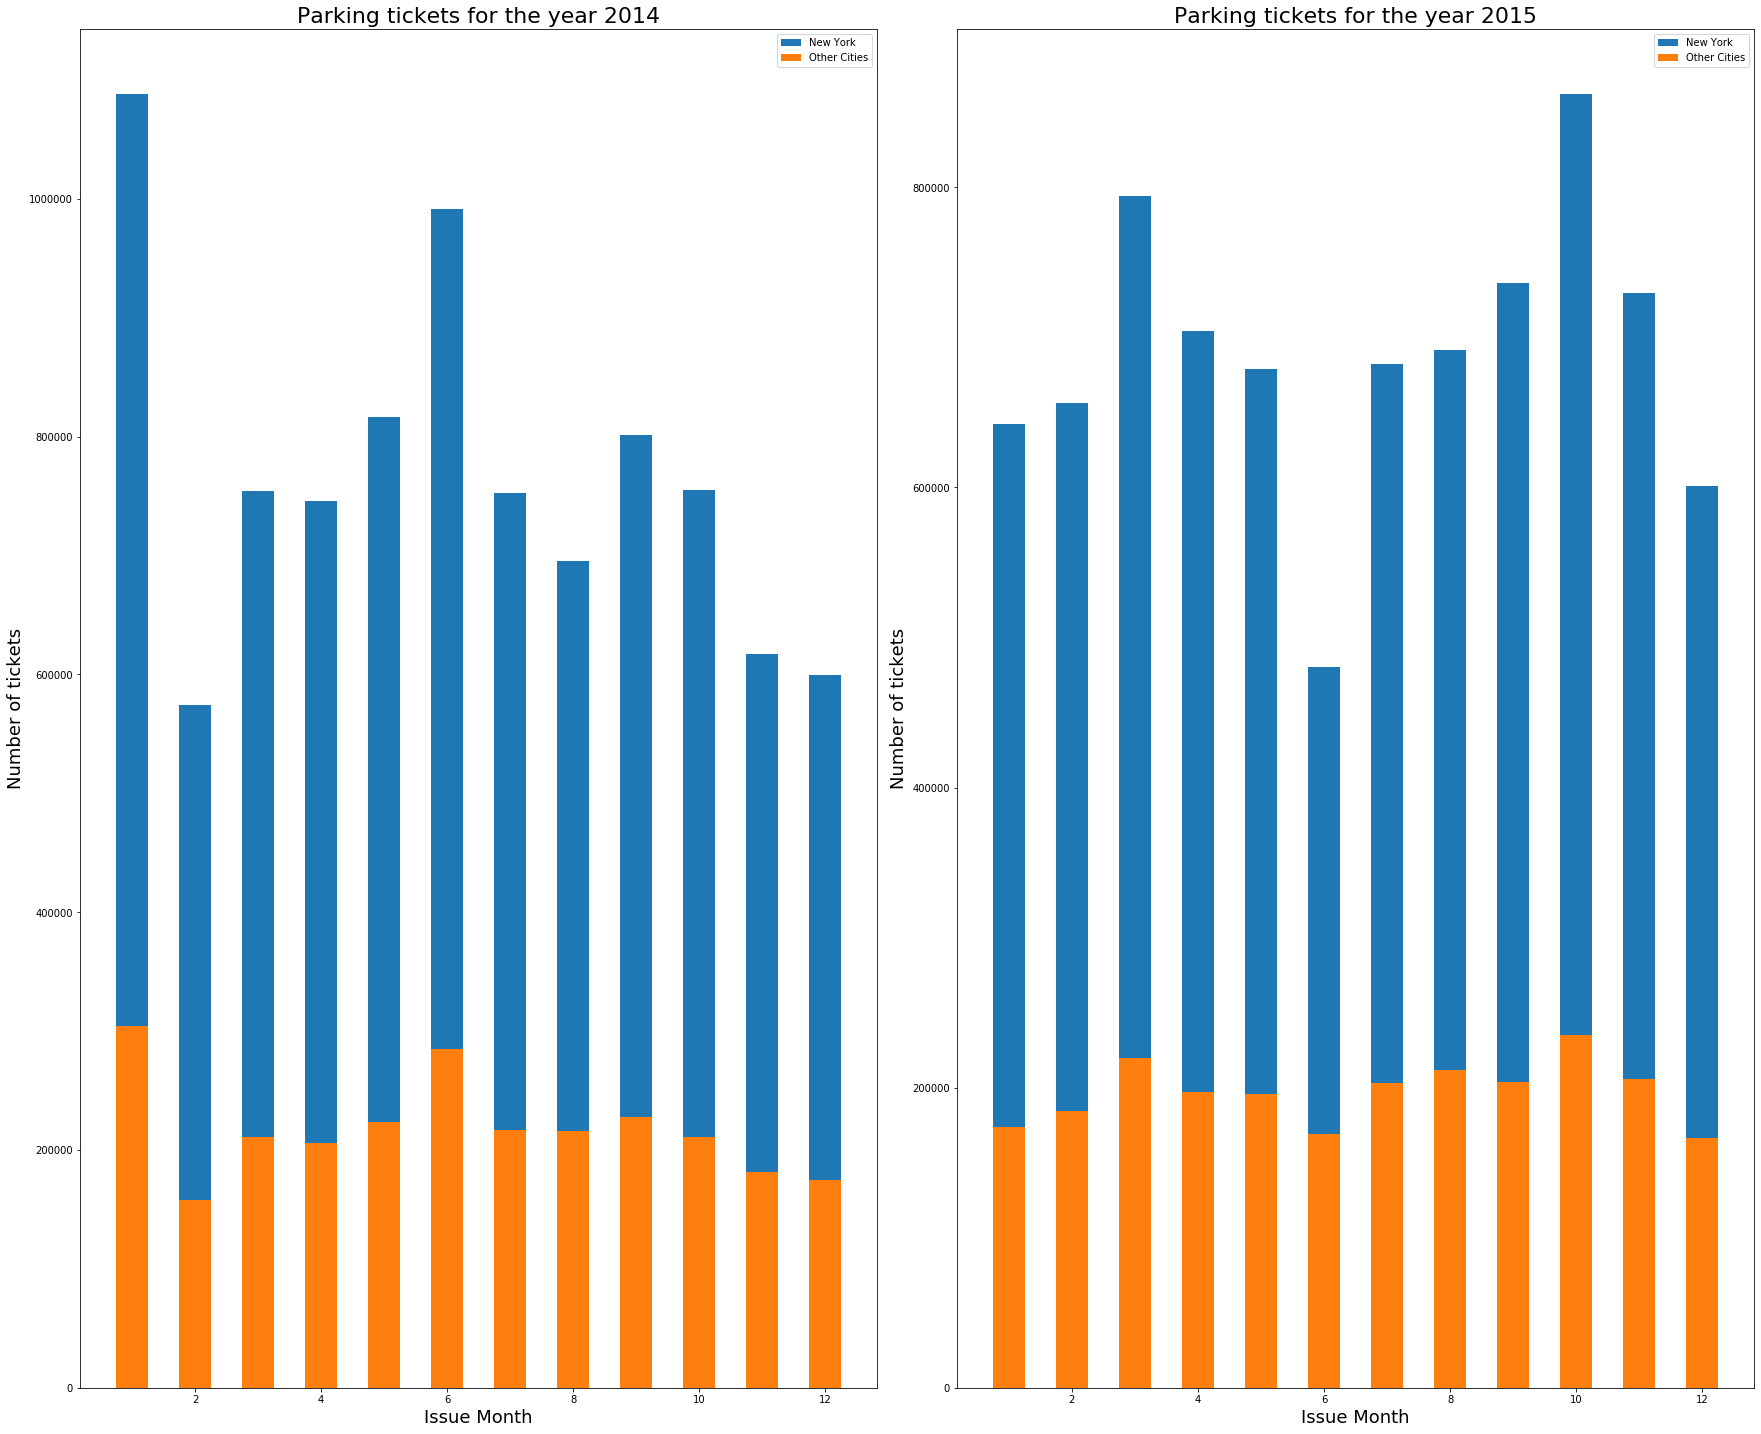

In [24]:
%%time

groupby = 'Issue Month'
EDA(tickets, year, groupby, 'bar', [int(len(year)/2),2], plot_data)

In [17]:
## Pie chart
%%time

groupby = 'Violation Code'
plot_data = []
EDA(tickets, year, groupby, 'pie', [int(len(year)/2),2], plot_data)

Failed to plot!
Failed to plot!
Failed to plot!


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f6194c37170> (for post_execute):


KeyboardInterrupt: 

In [19]:
sc.stop()